In [62]:
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Utility Functions

In [63]:
def Subset(E,t):
    if(isinstance(t, list)):
        return E[E['type'].isin(t)]
    else:
        return E[E.type==t]

def euclidean_distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def Dist(ei, ej):
    # Convert single points to a list for uniform handling
    if not isinstance(ei, list):
        ei = [ei]
    if not isinstance(ej, list):
        ej = [ej]
    # Calculate minimum distance
    return min(euclidean_distance(a, b) for a in ei for b in ej)

def Closest(e, S, R=np.inf):
    min_distance = [float('inf'),float('inf')]
    closest_point = [-1,-1]

    for i,s in S.iterrows():
        if(e.name != s.name):
            if(isinstance(e.coor, tuple)):
                distance = Dist(e.coor, s.coor)
                if distance <= min_distance[0] and distance < R:
                    min_distance[0] = distance
                    closest_point[0] = i
            else:
                for coor_ind in [0,-1]:
                    c = e.coor[coor_ind]
                    distance = Dist(c, s.coor)
                    if distance <= min_distance[coor_ind] and distance < R:
                        min_distance[coor_ind] = distance
                        closest_point[np.abs(coor_ind)] = i
    closest_point = [i for i in closest_point if i!=-1]
    return closest_point

def AddConnectionstoElement(elements, index, connections):
    existing_connections = elements.at[index, f'connections']
    if(existing_connections):
        for c in connections:
            if(c not in existing_connections):
                existing_connections.append(c)
        elements.at[index, f'connections'] = existing_connections
    else:
        elements.at[index, f'connections'] = connections
def RemoveConnectionstoElement(elements, index, connections):
    existing_connections = elements.at[index, f'connections']
    for c in connections:
        if(c in existing_connections):
            existing_connections.remove(c)
    elements.at[index, f'connections'] = existing_connections

def ReadFiles(folder_path, symbol='e'):
    elements = pd.DataFrame()

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            print(file_path)

            df = pd.read_csv(file_path, delimiter=';')

            df['coor'] = df['coor'].apply(ast.literal_eval)
            df['type'] = filename[2:-4]

            elements = pd.concat([elements,df], ignore_index=True)
    id_column = 'ID'
    IDs = [f"${symbol}_/{i+1}|$" for i in range(len(elements))]
    elements[id_column] = [id.replace('/','{').replace('|','}') for id in IDs]
    elements['connections'] = None
    elements.insert(0, id_column, elements.pop(id_column))

    return elements

def PlotElements(df):
    fig, ax = plt.subplots(figsize=(10, 8))

    for index, row in df.iterrows():
        if isinstance(row['coor'], list):
            line_coords = list(zip(*row['coor']))
            ax.plot(line_coords[0], line_coords[1], marker='o', label=row['ID'])
        else:
            ax.plot(row['coor'][0], row['coor'][1], marker='o', label=row['ID'])

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.legend()

    plt.show()

def StoreHinFile(file_path,hypothetical_paths,elements, short=False):
    print("Number of hypothetical paths:", len(hypothetical_paths))
    with open(file_path, 'w') as fp:
        if(short):
            fp.write("\n".join(str(item) for item in hypothetical_paths))
        else:
            fp.write("\n".join(str(elements.iloc[item].ID.values) for item in hypothetical_paths))

def HCustomer(H, customer):
    H_c = []
    for h in H:
        if(h[0]==customer.name):
            H_c.append(h)
    return H_c

def FindSwitches(elements, p, kind=0):
    switches = []
    for e in p:
        elem = elements.loc[e]
        if(elem.type=="switch"):
            if(kind==0):
                switches.append(e)
            else:
                status = 'close' if kind==1 else 'open'
                if(elem.status==status):
                    switches.append(e)
    return switches
def IsSwitchinPath(elements, p):
    return len(FindSwitches(elements, p, 0))>0
def IsPathActive(elements, p):
    return len(FindSwitches(elements, p, 2))==0
def IsPathBackup(elements, p):
    return len(FindSwitches(elements, p, 2))>0

def HCustomerActive(H, customer, elements):
    H_c = HCustomer(H, customer)
    H_c_a = []
    for h in H_c:
        if(IsPathActive(elements,h)):
            H_c_a.append(h)
    return H_c_a
def HCustomerBackup(H, customer, elements):
    H_c = HCustomer(H, customer)
    H_c_a = []
    for h in H_c:
        if(IsPathBackup(elements,h)):
            H_c_a.append(h)
    return H_c_a

def Diagnostic(H,E):
    number_of_problems = 0

    #Condition 1
    for _,c in Subset(E, "customer").iterrows():
        H_c_a = HCustomerActive(H, c, E)
        if(len(H_c_a)>1):
            print(f"Customer --\{c.ID} (index: {c.name})-- has more than 1 active path. {len(H_c_a)} paths existing: ({H_c_a})")
            number_of_problems += 1
    
    #Condition X (it is possible to add as many conditions as needed)

    if(number_of_problems==0):
        print("No issues found!")


# Raw Information

- $\mathcal{I}$ = {
    - i_1: A document containing the DSO's list of elements, their coordinates, and their types. Some elements may be missing, and the coordinates may be inaccurate.

    - i_2: The DSOs lack of information about the customers connections to the network and goal to minimise the cost of connecting customers to the grid. 
    - i_3: A technical meeting stating that for economical and efficiency factors, the connections between two elements must be not too long.
    - i_3: Information regarding the radial configuration of the distribution network.
    - i_4: DSOs goal to reduce energy losses by minimising the path length of each customer.
    - i_5: The knowledge that electricity distributed from one transformer cannot be transmitted to another transformer.  
}

# Well-Defined Information

- $\mathcal{I}'$ = {
    - $i'_1 = f_1(i_1)$: Sets of elements, their properties like coordinates and types.
    - $i'_2 = f_2(i_2)$: Elements of type $customer$ are connected to the closest element of type $line$.
    - $i'_3 = f_3(i_3)$: Elements of type $transformer$, $line$ and $switch$ cannot be connected to an element whose distance calculated using the elements GIS coordinates is greater than $R$.
    - $i'_4  = f_4(i_4)$: The total length of a path, defined as the sum of the lengths of the single lines, is at most $L$.  
}

# Read Elements

In [64]:
#Set of all Real Elements. These elements represent all the elements that is possible to find in the academic example
real_elements = ReadFiles("RealElements")
real_types = set(real_elements.type)
#Set of all DSO Elements. These elements represent the elements that is DSO knows about
elements = ReadFiles("DSOElements", symbol="\hat/e|")
types = set(elements.type)

RealElements/1_transformer.csv
RealElements/2_line.csv
RealElements/3_switch.csv
RealElements/4_customer.csv
DSOElements/1_transformer.csv
DSOElements/2_line.csv
DSOElements/3_switch.csv
DSOElements/4_customer.csv


In [65]:
real_elements

,ID,coor,type,status,connections
0,$e_{1}$,"(232, 299)",transformer,NaN,None
1,$e_{2}$,"(399, 196)",transformer,NaN,None
2,$e_{3}$,"[(232, 299), (241, 298)]",line,NaN,None
3,$e_{4}$,"[(241, 298), (327, 297)]",line,NaN,None
4,$e_{5}$,"[(327, 297), (324, 287)]",line,NaN,None
5,$e_{6}$,"[(388, 295), (393, 292)]",line,NaN,None
6,$e_{7}$,"[(388, 295), (390, 193)]",line,NaN,None
7,$e_{8}$,"[(390, 193), (399, 196)]",line,NaN,None
8,$e_{9}$,"[(390, 193), (376, 191)]",line,NaN,None
9,$e_{10}$,"[(376, 191), (315, 191)]",line,NaN,None


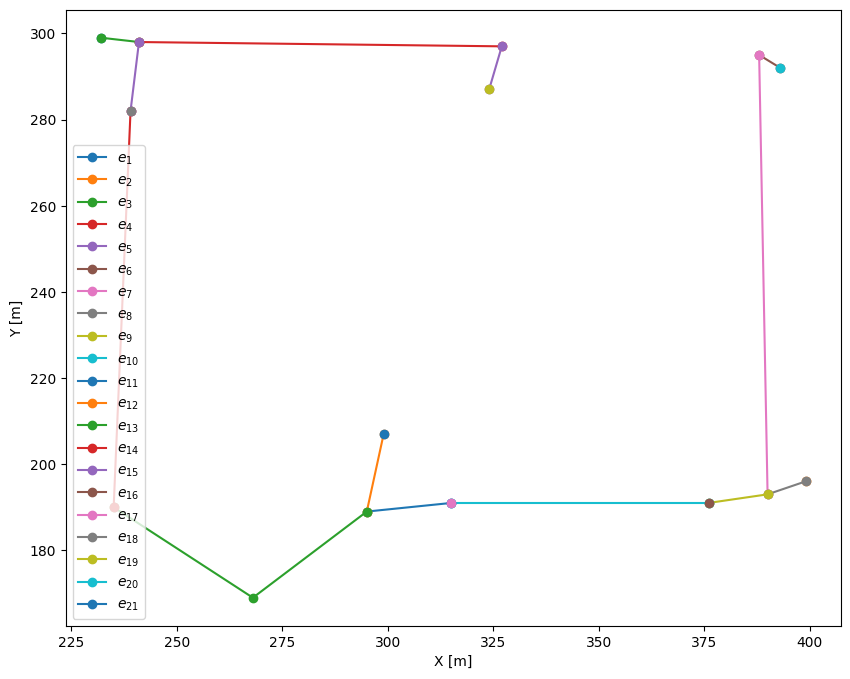

In [66]:
PlotElements(real_elements)

In [67]:
elements

,ID,coor,type,status,connections
0,$\hat{e}_{1}$,"(230, 297)",transformer,NaN,None
1,$\hat{e}_{2}$,"(401, 194)",transformer,NaN,None
2,$\hat{e}_{3}$,"[(240, 297), (328, 296)]",line,NaN,None
3,$\hat{e}_{4}$,"[(388, 295), (391, 193)]",line,NaN,None
4,$\hat{e}_{5}$,"[(390, 193), (374, 189)]",line,NaN,None
5,$\hat{e}_{6}$,"[(374, 189), (310, 191)]",line,NaN,None
6,$\hat{e}_{7}$,"[(293, 189), (235, 189)]",line,NaN,None
7,$\hat{e}_{8}$,"[(233, 189), (242, 282)]",line,NaN,None
8,$\hat{e}_{9}$,"(374, 189)",switch,close,None
9,$\hat{e}_{10}$,"(321, 289)",customer,NaN,None


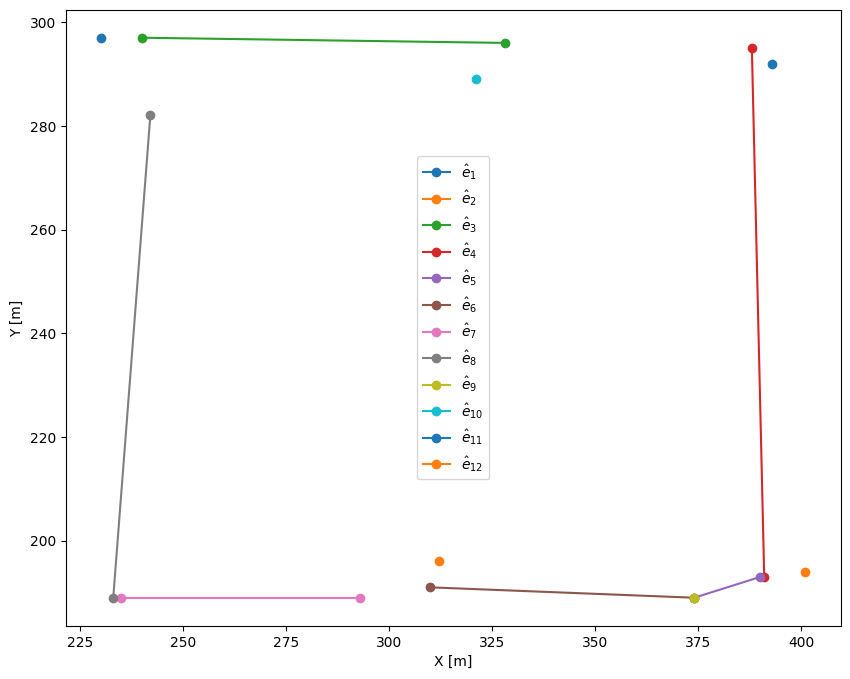

In [68]:
PlotElements(elements)

# Hypothetical Paths

In [69]:
from itertools import permutations

def calculate_hypothetical_paths(E, C, T):
    R = list(set(E) - set(C) - set(T))
    R.sort()
    print(f"E set: {E}. Len: {len(E)}")
    print(f"C set: {C}. Len: {len(C)}")
    print(f"T set: {T}. Len: {len(T)}")
    print(f"R set: {R}. Len: {len(R)}")
    H = []

    for i in range(len(R) + 1):
        for permutation in permutations(R, i):
            for c in C:
                for t in T:
                    path = [c] + [p for p in permutation] + [t]
                    H.append(path)

    return H

E = elements.index.values
C = Subset(elements,'customer').index.values
T = Subset(elements,'transformer').index.values

hypothetical_paths = calculate_hypothetical_paths(E, C, T)

E set: [ 0  1  2  3  4  5  6  7  8  9 10 11]. Len: 12
C set: [ 9 10 11]. Len: 3
T set: [0 1]. Len: 2
R set: [2, 3, 4, 5, 6, 7, 8]. Len: 7


In [70]:
StoreHinFile('hypotheticalpaths.txt', hypothetical_paths, elements)

Number of hypothetical paths: 82200


# Hypothetical Paths Compatible with the Well-Defined Information

## $\mathcal{H}^{i'_2}$

In [71]:
for i,c in Subset(elements, "customer").iterrows():
    possible_elements = Subset(elements, list(types.difference(["customer"])))
    closest_element = Closest(c, possible_elements)
    elements.at[i, 'connections'] = closest_element
    elements.at[closest_element[0], 'connections'] = [i]

In [72]:
hp = hypothetical_paths
compatible_hp = list(hp)
length_H_before = len(hp)
print(f'Length H before: {length_H_before}')

paths_removed = 0
for id_path,h in enumerate(hp):
    for id_customer,c in Subset(elements, "customer").iterrows():
        if(h[0]==id_customer and h[1]!=c['connections'][0]):
            compatible_hp.pop(id_path-paths_removed)
            paths_removed+=1
length_H_after = len(compatible_hp)
print(f'Length H after: {length_H_after}. Reduction: {((length_H_before-length_H_after)/length_H_before*100):.2f}%')
compatible_hypothetical_paths_i2 = compatible_hp

Length H before: 82200
Length H after: 11742. Reduction: 85.72%


In [73]:
StoreHinFile('compatible_hypothetical_paths_i2.txt', compatible_hypothetical_paths_i2, elements)

Number of hypothetical paths: 11742


## $\mathcal{H}^{i'_2, i'_3}$

In [74]:
R = 40
for t in list(types.difference(["customer"])):
    for index,elem in Subset(elements, t).iterrows():
        possible_elements = Subset(elements, list(types.difference(["customer"])))
        closest_elements = Closest(elem, possible_elements, R=R)
        
        #Adding connections to element: elem
        AddConnectionstoElement(elements, index, closest_elements)

        #Adding connections to element(s) in closest_elements
        for c in closest_elements:
            AddConnectionstoElement(elements, c, [index])

In [75]:
hp = compatible_hypothetical_paths_i2
compatible_hp = list(hp)
length_H_before = len(hp)
print(f'Length H before: {length_H_before}')
ds = []
paths_removed = 0
for id_path,h in enumerate(hp):
    for i in range(1,len(h)-1):
        h_ei = elements.iloc[h[i]].coor
        h_ej = elements.iloc[h[i+1]].coor
        d = Dist(h_ei,h_ej)
        ds.append(d)
        if(d>R):
            compatible_hp.pop(id_path-paths_removed)
            paths_removed+=1
            break
            
length_H_after = len(compatible_hp)
print(f'Length H after: {length_H_after}. Reduction: {((length_H_before-length_H_after)/length_H_before*100):.2f}%')
compatible_hypothetical_paths_i2i3 = compatible_hp

Length H before: 11742
Length H after: 62. Reduction: 99.47%


In [76]:
StoreHinFile('compatible_hypothetical_paths_i2i3.txt', compatible_hypothetical_paths_i2i3, elements)

Number of hypothetical paths: 62


## $\mathcal{H}^{i'_2, i'_3, i'_4}$

In [77]:
L = 400

hp = compatible_hypothetical_paths_i2i3
compatible_hp = list(hp)
length_H_before = len(hp)
print(f'Length H before: {length_H_before}')

paths_removed = 0
for id_path,h in enumerate(hp):
    l = 0
    for i in range(len(h)-1):
        h_ei = elements.iloc[h[i]].coor
        h_ej = elements.iloc[h[i+1]].coor
        d = Dist(h_ei,h_ej)
        l += d
        if(isinstance(h_ei,list)):
            l+=Dist(h_ei[0],h_ei[-1])

    if(l>L):
        compatible_hp.pop(id_path-paths_removed)
        paths_removed+=1
            
length_H_after = len(compatible_hp)
print(f'Length H after: {length_H_after}. Reduction: {((length_H_before-length_H_after)/length_H_before*100):.2f}%')
compatible_hypothetical_paths_i2i3i4 = compatible_hp

Length H before: 62
Length H after: 46. Reduction: 25.81%


In [78]:
StoreHinFile('compatible_hypothetical_paths_i2i3i4.txt', compatible_hypothetical_paths_i2i3i4, elements)

Number of hypothetical paths: 46


## $\mathcal{H}^{\mathcal{I}'}$

In [79]:
hp = compatible_hypothetical_paths_i2i3i4
compatible_hp = list(hp)
length_H_before = len(hp)
print(f'Length H before: {length_H_before}')

paths_removed = 0
for id_path,h in enumerate(hp):
    l = 0
    for i in range(len(h)-1):
        h_ei = elements.iloc[h[i]]
        h_ej = elements.iloc[h[i+1]]
        if(h[i+1] not in h_ei.connections):
            compatible_hp.pop(id_path-paths_removed)
            paths_removed+=1
            break
            
length_H_after = len(compatible_hp)
print(f'Length H after: {length_H_after}. Reduction: {((length_H_before-length_H_after)/length_H_before*100):.2f}%')
compatible_hypothetical_paths_I = compatible_hp

Length H before: 46
Length H after: 4. Reduction: 91.30%


In [80]:
StoreHinFile("compatible_hypothetical_paths_I'.txt", compatible_hypothetical_paths_I, elements)

Number of hypothetical paths: 4


# Diagnostic Function

In [81]:
Diagnostic(compatible_hypothetical_paths_I, elements)

Customer --\$\hat{e}_{12}$ (index: 11)-- has more than 1 active path. 2 paths existing: ([[11, 5, 6, 7, 2, 0], [11, 5, 8, 4, 3, 1]])


## Adjusting Well-Defined information

- $i'_5  = f_5(i_5)$: Element of type $switch$ location and status are chosen such that no customer can be supplied by no more than one transformer.

## New $\mathcal{H}^{\mathcal{I}'}$

In [82]:
from copy import deepcopy
H_c_a = deepcopy(HCustomerActive(compatible_hypothetical_paths_I, elements.loc[11], elements))

for index in range(len(H_c_a[0])):
    found = False
    elem = []
    for h in H_c_a:
        if(elem==[]):
            elem.append(h[index])
        elif(h[index] not in elem):
            found = True
            break
    if(found):
        break

#add switch
for h in H_c_a:
    elements_possibility = deepcopy(elements)
    if(IsSwitchinPath(elements,h)==False):
        new_switch = {"ID":"hat{e}"+str(len(elements)+1), "coor": elements.at[h[index-1], 'coor'][1], "type":'switch', "status":"open", "connections":[h[index-1], h[index]]}
        RemoveConnectionstoElement(elements, h[index-1], [h[index]])
        RemoveConnectionstoElement(elements, h[index], [h[index-1]])
        elements_possibility = pd.concat([elements_possibility,pd.DataFrame([new_switch])], ignore_index=True)
        compatible_hypothetical_paths_I.remove(h)
        h.insert(index, len(elements_possibility)-1)
        compatible_hypothetical_paths_I.append(h)
        break
elements = elements_possibility

In [83]:
Diagnostic(compatible_hypothetical_paths_I, elements)

No issues found!


# $\mathcal{H}^{\mathcal{I}'}_c$, $\mathcal{H}^{\mathcal{I}'}_{c,a}$ and $\mathcal{H}^{\mathcal{I}'}_{c,b}$

In [84]:
for _,c in Subset(elements, "customer").iterrows():
    print(f'Customer: {c.ID}')
    for h in HCustomer(compatible_hypothetical_paths_I, c):
        print([elements.loc[i].ID for i in h])
    print()

Customer: $\hat{e}_{10}$
['$\\hat{e}_{10}$', '$\\hat{e}_{3}$', '$\\hat{e}_{1}$']

Customer: $\hat{e}_{11}$
['$\\hat{e}_{11}$', '$\\hat{e}_{4}$', '$\\hat{e}_{2}$']

Customer: $\hat{e}_{12}$
['$\\hat{e}_{12}$', '$\\hat{e}_{6}$', '$\\hat{e}_{9}$', '$\\hat{e}_{5}$', '$\\hat{e}_{4}$', '$\\hat{e}_{2}$']
['$\\hat{e}_{12}$', '$\\hat{e}_{6}$', 'hat{e}13', '$\\hat{e}_{7}$', '$\\hat{e}_{8}$', '$\\hat{e}_{3}$', '$\\hat{e}_{1}$']



In [85]:
for _,c in Subset(elements, "customer").iterrows():
    print(f'Customer: {c.ID}')
    for h in HCustomerActive(compatible_hypothetical_paths_I, c, elements):
        print([elements.loc[i].ID for i in h])
    print()

Customer: $\hat{e}_{10}$
['$\\hat{e}_{10}$', '$\\hat{e}_{3}$', '$\\hat{e}_{1}$']

Customer: $\hat{e}_{11}$
['$\\hat{e}_{11}$', '$\\hat{e}_{4}$', '$\\hat{e}_{2}$']

Customer: $\hat{e}_{12}$
['$\\hat{e}_{12}$', '$\\hat{e}_{6}$', '$\\hat{e}_{9}$', '$\\hat{e}_{5}$', '$\\hat{e}_{4}$', '$\\hat{e}_{2}$']



In [86]:
for _,c in Subset(elements, "customer").iterrows():
    print(f'Customer: {c.ID}')
    for h in HCustomerBackup(compatible_hypothetical_paths_I, c, elements):
        print([elements.loc[i].ID for i in h])
    print()

Customer: $\hat{e}_{10}$

Customer: $\hat{e}_{11}$

Customer: $\hat{e}_{12}$
['$\\hat{e}_{12}$', '$\\hat{e}_{6}$', 'hat{e}13', '$\\hat{e}_{7}$', '$\\hat{e}_{8}$', '$\\hat{e}_{3}$', '$\\hat{e}_{1}$']

